# Mercedes-Benz greener manufacturing

In [1]:
!pip install category_encoders

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import category_encoders as ce
import featuretools as ft
import h2o

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import TransformedTargetRegressor

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.preprocessing import RobustScaler, MinMaxScaler, Normalizer
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.feature_selection import SelectPercentile, SelectFromModel, f_regression
from sklearn.decomposition import PCA

In [3]:
train_data = pd.read_csv('mercedes-benz-greener-manufacturing/train.csv.zip')
test_data = pd.read_csv('mercedes-benz-greener-manufacturing/test.csv.zip')
sample_subm = pd.read_csv('mercedes-benz-greener-manufacturing/sample_submission.csv.zip')

In [4]:
train_data

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,8405,107.39,ak,s,as,c,d,aa,d,q,...,1,0,0,0,0,0,0,0,0,0
4205,8406,108.77,j,o,t,d,d,aa,h,h,...,0,1,0,0,0,0,0,0,0,0
4206,8412,109.22,ak,v,r,a,d,aa,g,e,...,0,0,1,0,0,0,0,0,0,0
4207,8415,87.48,al,r,e,f,d,aa,l,u,...,0,0,0,0,0,0,0,0,0,0


In [5]:
len(train_data.columns)

378

array([[<AxesSubplot:title={'center':'y'}>]], dtype=object)

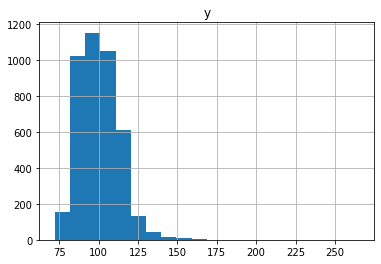

In [6]:
train_data.hist('y', bins=20)

In [7]:
train_data['y'].describe()

count    4209.000000
mean      100.669318
std        12.679381
min        72.110000
25%        90.820000
50%        99.150000
75%       109.010000
max       265.320000
Name: y, dtype: float64

In [8]:
test_data

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,1,az,v,n,f,d,t,a,w,0,...,0,0,0,1,0,0,0,0,0,0
1,2,t,b,ai,a,d,b,g,y,0,...,0,0,1,0,0,0,0,0,0,0
2,3,az,v,as,f,d,a,j,j,0,...,0,0,0,1,0,0,0,0,0,0
3,4,az,l,n,f,d,z,l,n,0,...,0,0,0,1,0,0,0,0,0,0
4,5,w,s,as,c,d,y,i,m,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,8410,aj,h,as,f,d,aa,j,e,0,...,0,0,0,0,0,0,0,0,0,0
4205,8411,t,aa,ai,d,d,aa,j,y,0,...,0,1,0,0,0,0,0,0,0,0
4206,8413,y,v,as,f,d,aa,d,w,0,...,0,0,0,0,0,0,0,0,0,0
4207,8414,ak,v,as,a,d,aa,c,q,0,...,0,0,1,0,0,0,0,0,0,0


In [9]:
train_data.dtypes.value_counts()

int64      369
object       8
float64      1
dtype: int64

In [10]:
#how much NaN in data
train_data.isna().sum().sum()

0

In [11]:
test_frame = []
for s in train_data.iloc[:, range(10, train_data.shape[1])]:
    test_frame.append(train_data[s].value_counts().to_frame())

pd.concat(test_frame, axis=1)

#only 0 and 1 in X10..X385

,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,4153,4209.0,3893,3965,2407,4207,4198,4177,4176,3790,...,2867,3968,2884,4122,4169,4175,4177,4202,4207,4203
1,56,NaN,316,244,1802,2,11,32,33,419,...,1342,241,1325,87,40,34,32,7,2,6


Можно заметить, что в наборе данных присутствуют признаки, значения которых варируются "не сильно"

In [12]:
categorical_columns = []
binary_columns = []
for columns in train_data.columns:
    if train_data[columns].dtype == object:
        categorical_columns.append(columns)
    else:
        binary_columns.append(columns)
#print(categorical_columns, binary_columns)

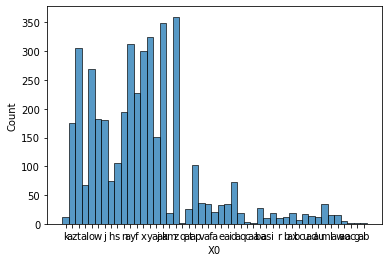

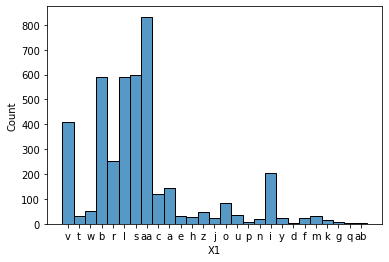

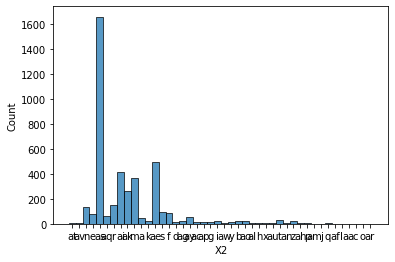

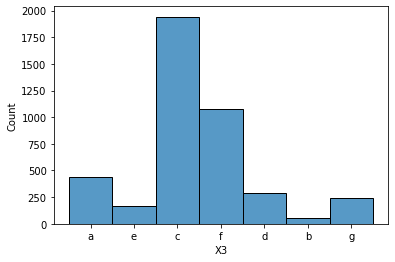

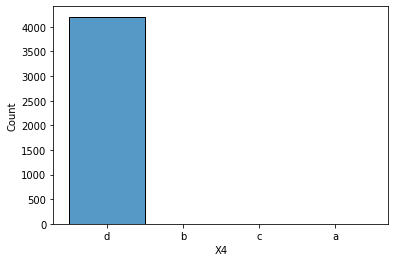

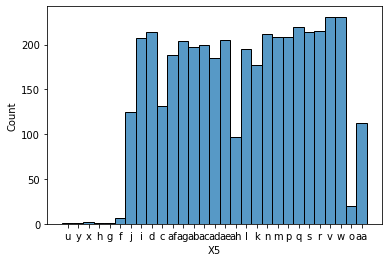

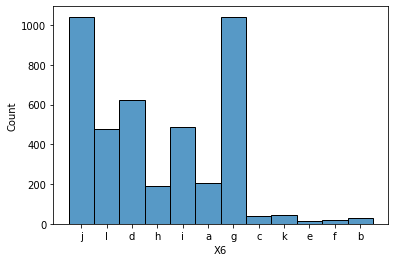

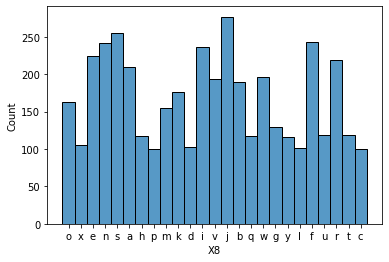

In [13]:
for col in categorical_columns:
    sns.histplot(train_data[col])
    plt.show()

Признак X4 выглядит подозрительно невариативно

In [14]:
def get_x_y_separate_with_id(df):
    return df.drop(['y'],axis=1), df['y']

def get_x_y_separate_without_id(df):
    return df.drop(['ID', 'y'],axis=1), df['y']

In [15]:
noid_X_train, noid_y_train = get_x_y_separate_without_id(train_data)

In [16]:
id_X_train, id_y_train = get_x_y_separate_with_id(train_data)

# Leave One Out Encoder and 3 models

## BayesianRidge

In [17]:
k_fold = KFold(5, random_state=42, shuffle=True)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(noid_X_train, noid_y_train, test_size=0.05, random_state=42)

In [19]:
pipeline_only_encoding_br = Pipeline([
    ('encoder', ce.LeaveOneOutEncoder()),
    ('regressor', BayesianRidge()),
])

In [20]:
scores_br = cross_val_score(
    pipeline_only_encoding_br, X_train, y_train, 
    cv=k_fold, scoring='r2'
)

In [21]:
scores_br

array([0.6208081 , 0.59444296, 0.46718812, 0.55862679, 0.55535491])

In [22]:
print('Cross-validated R2: %0.3f +/- %0.3f' % (scores_br.mean(), scores_br.std()))

Cross-validated R2: 0.559 +/- 0.052


In [23]:
pipeline_only_encoding_br.fit(X_train, y_train)

Pipeline(steps=[('encoder',
                 LeaveOneOutEncoder(cols=['X0', 'X1', 'X2', 'X3', 'X4', 'X5',
                                          'X6', 'X8'])),
                ('regressor', BayesianRidge())])

In [24]:
pipeline_only_encoding_br.score(X_train, y_train)

0.5816860206812092

In [25]:
pipeline_only_encoding_br.score(X_test, y_test)

0.6302058761034481

## DecisionTree

In [26]:
pipeline_only_encoding_dt = Pipeline([
    ('encoder', ce.LeaveOneOutEncoder()),
    ('regressor', DecisionTreeRegressor(max_depth=10, random_state=42)),
])

In [27]:
scores_dt = cross_val_score(
    pipeline_only_encoding_dt, X_train, y_train, 
    cv=k_fold, scoring='r2'
)

In [28]:
print('Cross-validated R2: %0.3f +/- %0.3f' % (scores_dt.mean(), scores_dt.std()))

Cross-validated R2: -0.004 +/- 0.005


## RandomForest

In [29]:
pipeline_only_encoding_rf = Pipeline([
    ('encoder', ce.LeaveOneOutEncoder()),
    ('regressor', RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)),
])

In [30]:
scores_rf = cross_val_score(
    pipeline_only_encoding_rf, X_train, y_train, 
    cv=k_fold, scoring='r2'
)

In [31]:
scores_rf

array([-0.00050213, -0.00069332, -0.00069217, -0.00134956, -0.00027045])

In [32]:
print('Cross-validated R2: %0.3f +/- %0.3f' % (scores_rf.mean(), scores_rf.std()))

Cross-validated R2: -0.001 +/- 0.000


# Добавим FeatureTools

In [33]:
from featuretools.wrappers import DFSTransformer
from featuretools.primitives import MultiplyBoolean
from featuretools.primitives import NumUnique

In [34]:
variable_types = {}
for column in categorical_columns:
    variable_types[column] = ft.variable_types.Categorical
for column in binary_columns:
    if column == 'ID' or column =='y':
        continue
    variable_types[column] = ft.variable_types.Boolean

In [35]:
id_x_train, id_y_train = get_x_y_separate_with_id(train_data)

In [36]:
X_train_id, X_test_id, y_train_id, y_test_id = train_test_split(id_X_train, id_y_train, test_size=0.05, random_state=42)

In [37]:
es_tr = ft.EntitySet(id='cars_info')
es_tr = es_tr.entity_from_dataframe(entity_id='cars_info', dataframe=X_train_id, index='ID', variable_types=variable_types)

In [38]:
pipeline_ft_br = Pipeline([
    ('ft', DFSTransformer(target_entity='cars_info', trans_primitives = [MultiplyBoolean()],
              max_depth=1, max_features=1000)),
    ('encoder', ce.LeaveOneOutEncoder()),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('regressor', BayesianRidge()),
])

In [39]:
pipeline_ft_br.fit(es_tr, y_train_id)

c:\users\akagi\documents\otus\1-automl\env\lib\site-packages\pandas\core\frame.py:4481: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[k] = com.apply_if_callable(v, data)


Pipeline(steps=[('ft',
                 <featuretools_sklearn_transformer.transformer.DFSTransformer object at 0x000002DE16F1D5B0>),
                ('encoder',
                 LeaveOneOutEncoder(cols=['X0', 'X1', 'X2', 'X3', 'X4', 'X5',
                                          'X6', 'X8'])),
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('regressor', BayesianRidge())])

In [40]:
pipeline_ft_br.score(es_tr, y_train_id)

c:\users\akagi\documents\otus\1-automl\env\lib\site-packages\pandas\core\frame.py:4481: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[k] = com.apply_if_callable(v, data)


0.5775038408994175

In [41]:
es_test = ft.EntitySet(id='cars_info')
es_test = es_test.entity_from_dataframe(entity_id='cars_info', dataframe=X_test_id, index='ID', variable_types=variable_types)

In [42]:
pipeline_ft_br.score(es_test, y_test_id)

c:\users\akagi\documents\otus\1-automl\env\lib\site-packages\pandas\core\frame.py:4481: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[k] = com.apply_if_callable(v, data)


0.6237903330478138

# Добавим фильтрацию

In [43]:
X_train, X_test, y_train, y_test = train_test_split(noid_X_train, noid_y_train, test_size=0.05, random_state=42)
k_fold = KFold(5, random_state=42, shuffle=True)

In [44]:
class CorrSelector:
    def __init__(self, threshold):
        self.threshold = threshold
    
    def fit(self, X, y=None):
        corr = np.absolute(np.corrcoef(X, rowvar=False))
        upper = corr*np.triu(np.ones(corr.shape), k=1).astype(bool)
        self.to_drop = [column for column in range(upper.shape[1]) if any(upper[:,column] >= self.threshold)]
        return self
    
    def transform(self, X):
        return np.delete(X, self.to_drop, axis=1)

In [45]:
pipeline_filt_br = Pipeline([
    ('encoder', ce.LeaveOneOutEncoder()),
    ('filter_var', VarianceThreshold(.99 * (1 - .99))),
    ('correlated_remover', CorrSelector(.99)),
    ('from_model', SelectFromModel(BayesianRidge())),
    ('regressor', BayesianRidge()),
])

In [46]:
scores_filt_br = cross_val_score(
    pipeline_only_encoding_br, X_train, y_train, 
    cv=k_fold, scoring='r2'
)

c:\users\akagi\documents\otus\1-automl\env\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
c:\users\akagi\documents\otus\1-automl\env\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
c:\users\akagi\documents\otus\1-automl\env\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
c:\users\akagi\documents\otus\1-automl\env\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categor

In [47]:
pipeline_filt_br.fit(X_train, y_train)

Pipeline(steps=[('encoder',
                 LeaveOneOutEncoder(cols=['X0', 'X1', 'X2', 'X3', 'X4', 'X5',
                                          'X6', 'X8'])),
                ('filter_var',
                 VarianceThreshold(threshold=0.00990000000000001)),
                ('correlated_remover',
                 <__main__.CorrSelector object at 0x000002DE24CEA8B0>),
                ('from_model', SelectFromModel(estimator=BayesianRidge())),
                ('regressor', BayesianRidge())])

In [48]:
pipeline_filt_br.score(X_train, y_train)

0.5824849288577093

In [49]:
pipeline_filt_br.score(X_test, y_test)

0.6322544558797966

In [50]:
#pipeline_filt_br.fit_transform(X_train, y_train).shape

In [51]:
print('Cross-validated R2: %0.3f +/- %0.3f' % (scores_filt_br.mean(), scores_filt_br.std()))

Cross-validated R2: 0.559 +/- 0.052


#### some experiments

In [52]:
pipeline_filt_br_tr = TransformedTargetRegressor(Pipeline([
    ('encoder', ce.LeaveOneOutEncoder()),
    ('filter_var', VarianceThreshold(.99 * (1 - .99))),
    ('correlated_remover', CorrSelector(.99)),
    ('from_model', SelectFromModel(BayesianRidge())),
    ('regressor', BayesianRidge()),
]), transformer=RobustScaler())

In [53]:
scores_filt_br_tr = cross_val_score(
    pipeline_filt_br_tr, X_train, y_train, 
    cv=k_fold, scoring='r2'
)

In [54]:
print('Cross-validated R2: %0.3f +/- %0.3f' % (scores_filt_br_tr.mean(), scores_filt_br_tr.std()))

Cross-validated R2: 0.555 +/- 0.055


In [55]:
pipeline_filt_br_tr.fit(X_train, y_train); 
pipeline_filt_br_tr.score(X_train, y_train), pipeline_filt_br_tr.score(X_test, y_test)

(0.5828964434380449, 0.6287586691170041)

In [56]:
pipeline_filt_br_rf = Pipeline([
    ('encoder', ce.LeaveOneOutEncoder()),
    ('filter_var', VarianceThreshold(.99 * (1 - .99))),
    ('correlated_remover', CorrSelector(.99)),
    ('from_model', SelectFromModel(RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42))),
    ('regressor', BayesianRidge()),
])

In [57]:
pipeline_filt_br_rf.fit(X_train, y_train); 
pipeline_filt_br_rf.score(X_train, y_train), pipeline_filt_br_rf.score(X_test, y_test)

(0.5711580633946728, 0.6368829225938665)

In [58]:
scores_filt_br_rf = cross_val_score(
    pipeline_filt_br_rf, X_train, y_train, 
    cv=k_fold, scoring='r2'
)

c:\users\akagi\documents\otus\1-automl\env\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
c:\users\akagi\documents\otus\1-automl\env\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
c:\users\akagi\documents\otus\1-automl\env\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
c:\users\akagi\documents\otus\1-automl\env\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categor

In [59]:
print('Cross-validated R2: %0.3f +/- %0.3f' % (scores_filt_br_rf.mean(), scores_filt_br_rf.std()))

Cross-validated R2: 0.464 +/- 0.234


In [60]:
pipeline_filt_rf = Pipeline([
    ('encoder', ce.LeaveOneOutEncoder()),
    ('filter_var', VarianceThreshold(.99 * (1 - .99))),
    ('correlated_remover', CorrSelector(.99)),
    ('from_model', SelectFromModel(RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42))),
    ('regressor', RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42)),
])

In [61]:
scores_filt_rf = cross_val_score(
    pipeline_filt_br_rf, X_train, y_train, 
    cv=k_fold, scoring='r2'
)

c:\users\akagi\documents\otus\1-automl\env\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
c:\users\akagi\documents\otus\1-automl\env\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
c:\users\akagi\documents\otus\1-automl\env\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
c:\users\akagi\documents\otus\1-automl\env\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categor

In [62]:
print('Cross-validated R2: %0.3f +/- %0.3f' % (scores_filt_rf.mean(), scores_filt_rf.std()))

Cross-validated R2: 0.464 +/- 0.234


In [63]:
pipeline_filt_rf.fit(X_train, y_train); 
pipeline_filt_rf.score(X_train, y_train), pipeline_filt_rf.score(X_test, y_test)

(0.3055739169618731, 0.37066606506719424)

Фильтрация признаков повышает работоспособность случайного леса, но для получения лучших результатов требуется более тщательный подбор гиперпараметров.

# Фильтрации с FT

In [64]:
pipeline_ft_br_filt = Pipeline([
    ('ft', DFSTransformer(target_entity='cars_info', trans_primitives = [MultiplyBoolean()],
              max_depth=1, max_features=1000)),
    ('encoder', ce.LeaveOneOutEncoder()),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('filter_var', VarianceThreshold(.99 * (1 - .99))),
    ('correlated_remover', CorrSelector(.99)),
    ('from_model', SelectFromModel(BayesianRidge())),
    ('regressor', BayesianRidge()),
])

In [65]:
pipeline_ft_br_filt.fit(es_tr, y_train_id)

c:\users\akagi\documents\otus\1-automl\env\lib\site-packages\pandas\core\frame.py:4481: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[k] = com.apply_if_callable(v, data)


Pipeline(steps=[('ft',
                 <featuretools_sklearn_transformer.transformer.DFSTransformer object at 0x000002DE24CD80A0>),
                ('encoder',
                 LeaveOneOutEncoder(cols=['X0', 'X1', 'X2', 'X3', 'X4', 'X5',
                                          'X6', 'X8'])),
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('filter_var',
                 VarianceThreshold(threshold=0.00990000000000001)),
                ('correlated_remover',
                 <__main__.CorrSelector object at 0x000002DE24CD8D30>),
                ('from_model', SelectFromModel(estimator=BayesianRidge())),
                ('regressor', BayesianRidge())])

In [66]:
pipeline_ft_br_filt.score(es_tr, y_train_id)

c:\users\akagi\documents\otus\1-automl\env\lib\site-packages\pandas\core\frame.py:4481: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[k] = com.apply_if_callable(v, data)


0.5651308443774441

In [67]:
pipeline_ft_br_filt.score(es_test, y_test_id)

c:\users\akagi\documents\otus\1-automl\env\lib\site-packages\pandas\core\frame.py:4481: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[k] = com.apply_if_callable(v, data)


0.6205721933851998

Ожидаемо, с FeatureTools были получены худшие результаты, нежели без него, т.к. признаки в модели довольно простые (категориальные или логические) + есть признаки, вариативность значений которых невысока.

# +PCA

In [68]:
pipeline_filt_pca_br = Pipeline([
    ('encoder', ce.LeaveOneOutEncoder()),
    ('filter_var', VarianceThreshold(.99 * (1 - .99))),
    ('correlated_remover', CorrSelector(.99)),
    ('from_model', SelectFromModel(BayesianRidge())),
    ('pca', PCA(n_components=30, random_state=42)),
    ('regressor', BayesianRidge()),
])

In [69]:
pipeline_filt_pca_br

Pipeline(steps=[('encoder', LeaveOneOutEncoder()),
                ('filter_var',
                 VarianceThreshold(threshold=0.00990000000000001)),
                ('correlated_remover',
                 <__main__.CorrSelector object at 0x000002DE1D0A2EE0>),
                ('from_model', SelectFromModel(estimator=BayesianRidge())),
                ('pca', PCA(n_components=30, random_state=42)),
                ('regressor', BayesianRidge())])

In [70]:
scores_filt_pca_br = cross_val_score(
    pipeline_filt_pca_br, X_train, y_train, 
    cv=k_fold, scoring='r2'
)

In [71]:
print('Cross-validated R2: %0.3f +/- %0.3f' % (scores_filt_pca_br.mean(), scores_filt_pca_br.std()))

Cross-validated R2: 0.558 +/- 0.053


In [72]:
pipeline_filt_pca_br.fit(X_train, y_train); 
pipeline_filt_pca_br.score(X_train, y_train), pipeline_filt_pca_br.score(X_test, y_test)

(0.5793840806718265, 0.6346615494982035)

# H2O AutoML

In [73]:
import h2o

from h2o.sklearn import H2OAutoMLRegressor
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.241-b07, mixed mode)
  Starting server from C:\Users\akagi\Documents\otus\1-automl\env\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\akagi\AppData\Local\Temp\tmple0zw4mi
  JVM stdout: C:\Users\akagi\AppData\Local\Temp\tmple0zw4mi\h2o_akagi_started_from_python.out
  JVM stderr: C:\Users\akagi\AppData\Local\Temp\tmple0zw4mi\h2o_akagi_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Moscow
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.4
H2O_cluster_version_age:,7 days and 21 minutes
H2O_cluster_name:,H2O_from_python_akagi_pmgn00
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.539 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


In [74]:
X_train, X_test, y_train, y_test = train_test_split(noid_X_train, noid_y_train.values, test_size=0.05, random_state=42)

pipeline_h2o = Pipeline([
    ('encoder', ce.LeaveOneOutEncoder()),
    ('filter_var', VarianceThreshold(.99 * (1 - .99))),
    ('correlated_remover', CorrSelector(.99)),
    #('featselect', SelectKBest(f_regression, k=10)),
    ('from_model', SelectFromModel(BayesianRidge())),
    ('classifier', H2OAutoMLRegressor(max_models=20, seed=42)),
    #
    #('regressor', BayesianRidge()),
])

In [75]:
pipeline_h2o.fit(X_train, y_train)
pipeline_h2o.score(X_train, y_train), pipeline_h2o.score(X_test, y_test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |
14:59:46.359: AutoML: XGBoost is not available; skipping it.

████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%


(0.4209055405500386, 0.4351456200627791)

In [91]:
X_test_id.insert(0, 'y', y_test_id)

In [85]:
from h2o.automl import H2OAutoML


X_train_id.insert(0, 'y', y_train_id)
X_test_id.insert(0, 'y', y_test_id)
train = h2o.H2OFrame(X_train_id)

x = [c for c in train_data.columns if c not in ('y', 'ID')]
y = 'y'

aml = H2OAutoML(max_models=20, seed=1)
aml.train(x=x, y=y, training_frame=train)
lb = aml.leaderboard
lb.head(rows=lb.nrows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |
15:09:17.795: AutoML: XGBoost is not available; skipping it.

████████████████████████████████████████████████████████| 100%


model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_BestOfFamily_AutoML_20210715_150917,70.9013,8.42029,70.9013,5.32755,0.0742499
GBM_grid__1_AutoML_20210715_150917_model_1,70.969,8.42431,70.969,5.32703,0.074297
StackedEnsemble_AllModels_AutoML_20210715_150917,70.9862,8.42533,70.9862,5.32919,0.0742899
GBM_grid__1_AutoML_20210715_150917_model_5,71.3896,8.44924,71.3896,5.35183,0.074535
GBM_grid__1_AutoML_20210715_150917_model_3,71.8781,8.47809,71.8781,5.36736,0.0749085
GBM_5_AutoML_20210715_150917,73.3889,8.56673,73.3889,5.48338,0.0759259
GLM_1_AutoML_20210715_150917,73.891,8.59599,73.891,5.5003,0.0762344
GBM_2_AutoML_20210715_150917,75.6951,8.7003,75.6951,5.57534,0.0772483
GBM_grid__1_AutoML_20210715_150917_model_4,75.8133,8.70708,75.8133,5.59794,0.0774003
DeepLearning_1_AutoML_20210715_150917,76.4392,8.74295,76.4392,5.59848,0.0778525


In [86]:
preds = aml.leader.predict(train)

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [88]:
r2_score(X_train_id['y'].values, preds.as_data_frame())

0.6133097172452362

In [92]:
test = h2o.H2OFrame(X_test_id)
preds = aml.leader.predict(test)
r2_score(X_test_id['y'].values, preds.as_data_frame())

Parse progress: |█████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%


c:\users\akagi\documents\otus\1-automl\env\lib\site-packages\h2o\job.py:72: UserWarning: Test/Validation dataset column 'X0' has levels not trained on: ["ac"]
  warnings.warn(w)
c:\users\akagi\documents\otus\1-automl\env\lib\site-packages\h2o\job.py:72: UserWarning: Test/Validation dataset column 'X2' has levels not trained on: ["j"]
  warnings.warn(w)


0.6411198857753693

In [93]:
X_train, X_test, y_train, y_test = train_test_split(noid_X_train, noid_y_train.values, test_size=0.05, random_state=42)

pipeline_h2o = Pipeline([
    ('encoder', ce.LeaveOneOutEncoder()),
    ('filter_var', VarianceThreshold(.99 * (1 - .99))),
    ('correlated_remover', CorrSelector(.99)),
    ('featselect', SelectKBest(f_regression, k=10)),
    #('from_model', SelectFromModel(BayesianRidge())),
    ('classifier', H2OAutoMLRegressor(max_models=20, seed=42)),
    #
    #('regressor', BayesianRidge()),
])

In [94]:
pipeline_h2o.fit(X_train, y_train)
pipeline_h2o.score(X_train, y_train), pipeline_h2o.score(X_test, y_test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |
15:37:21.238: AutoML: XGBoost is not available; skipping it.

████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%


(0.4608430333479244, 0.5345775870180824)